# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [2]:
# levantamos los datos
df = pd.read_csv('podcast_dataset.csv')

# peek
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


# Preprocessing

Ver notebook de EDA.

In [3]:
# drop duplicates
df.drop_duplicates(inplace=True)

# target relativo
df['fraction_listened'] = df['Listening_Time_minutes'] / df['Episode_Length_minutes']

# encoding de episode number
df['Episode_Number'] = df['Episode_Title'].apply(lambda x: x.split(" ")[-1]).astype(int)

# ausencia de guest
df['no_guest'] = df['Guest_Popularity_percentage'].isna()

# imputacion de NaNs
df.fillna({'Guest_Popularity_percentage':-1}, inplace=True)

# dropeo de NaNs de las otras columnas y reseteo de index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# encoding de sentiment
df['sentiment_encoded'] = df['Episode_Sentiment'].map({'Neutral':0, 'Negative':-1, 'Positive':1}).astype(int)

# drop de variables ahora redundantes
df.drop(columns=['Episode_Title', 'Episode_Sentiment'], inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 40374 non-null  object 
 1   Episode_Length_minutes       40374 non-null  float64
 2   Genre                        40374 non-null  object 
 3   Host_Popularity_percentage   40374 non-null  float64
 4   Publication_Day              40374 non-null  object 
 5   Publication_Time             40374 non-null  object 
 6   Guest_Popularity_percentage  40374 non-null  float64
 7   Number_of_Ads                40374 non-null  int64  
 8   Listening_Time_minutes       40374 non-null  float64
 9   fraction_listened            40374 non-null  float64
 10  Episode_Number               40374 non-null  int64  
 11  no_guest                     40374 non-null  bool   
 12  sentiment_encoded            40374 non-null  int64  
dtypes: bool(1), floa

# Baseline

Para este problema elegimos minimizar el MSE/RMSE, aunque también miramos el MAE.

In [5]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
#from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from tqdm import tqdm

In [6]:
X = df.drop(columns=['Listening_Time_minutes','fraction_listened'])
y_abs = df['Listening_Time_minutes']
y_rel = df['fraction_listened']

In [7]:
numeric_cols = X.columns[X.dtypes!='object'].tolist()
numeric_cols

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Number',
 'no_guest',
 'sentiment_encoded']

In [8]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
cat_cols

['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time']

In [9]:
# utils
def rel_to_abs(y_pred_rel, X):
    return y_pred_rel * X['Episode_Length_minutes']

METRICS = {
    'mae': mean_absolute_error,
    'mse': mean_squared_error,
    'rmse': root_mean_squared_error,
}

SPLITTER = KFold(n_splits=5, random_state=42, shuffle=True)

def cv_model(model_constructor_f, X, is_rel, model_args={}):
#    Entrena y evalúa un modelo usando validación cruzada con KFold.
#
#    Parámetros:
#        model_constructor_f: función o clase que construye el modelo (ej: RandomForestRegressor)
#        X: DataFrame con las variables independientes
#        is_rel: bool que indica si los valores de y son relativos y deben convertirse a absolutos
#        model_args: diccionario con los argumentos para construir el modelo
#
#    Devuelve:
#        - Un DataFrame con métricas por fold, más medias y desviaciones estándar
#        - Una lista con los modelos entrenados en cada fold
    results = []
    models = []
    for i, (train_idx, test_idx) in tqdm(enumerate(SPLITTER.split(X)), 
                                         total=SPLITTER.get_n_splits()):
        X_train = X.loc[train_idx]
        X_test = X.loc[test_idx]

        y_train = y_rel[train_idx] if is_rel else y_abs[train_idx]
        y_test = y_abs[test_idx]

        # inst+fit model
        model = model_constructor_f(**model_args)

        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)

        # if rel, adjust to abs
        if is_rel:
            y_pred = rel_to_abs(y_pred, X_test)

        results.append({name:f(y_test, y_pred) for name,f in METRICS.items()})
        models.append(model)

    res_df = pd.DataFrame(results)
    # add mean and std values across folds for all metrics
    return pd.concat((res_df, res_df.describe().loc[['mean','std']])), models

In [10]:
# gráfico de importancias across-folds
# utils
def lr_weights(
        models: Pipeline | LinearRegression | list[Pipeline] | list[LinearRegression],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    coefs = np.vstack([np.concatenate([*x.coef_, x.intercept_]) for x in models])
    df = pd.DataFrame(coefs, columns=feature_names+['intercept'])
    ax = sns.barplot(df, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"LR coefficients across evaluation procedure")
    plt.show()

def rf_importance(
        models: Pipeline | RandomForestRegressor | list[RandomForestRegressor] | list[Pipeline],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    df_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=feature_names)
    ax = sns.barplot(df_importances, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"RF feature importances across evaluation procedure")
    plt.show()

## Sobre target absoluto

In [11]:
X_only_numeric = X[numeric_cols]
X_only_numeric

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Number,no_guest,sentiment_encoded
0,99.25,21.37,70.22,3,77,False,1
1,19.43,47.19,75.15,1,6,False,0
2,117.03,96.33,57.95,3,1,False,0
3,16.97,25.73,24.19,0,38,False,1
4,28.06,22.02,-1.00,1,87,True,0
...,...,...,...,...,...,...,...
40369,92.44,27.34,63.54,3,77,False,1
40370,50.30,20.61,55.63,0,100,False,1
40371,89.78,93.08,93.12,3,12,False,1
40372,77.86,41.04,52.33,2,18,False,1


In [12]:
res_rf_abs, models_rf_abs = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=False,
    model_args=dict(n_jobs=-1)
)

100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


In [13]:
res_rf_abs

,mae,mse,rmse
0,9.068444,134.269547,11.587474
1,8.908232,130.777175,11.435785
2,8.978704,132.774420,11.522778
3,8.979264,132.507387,11.511185
4,9.048517,133.705851,11.563125
mean,8.996632,132.806876,11.524069
std,0.063810,1.337721,0.058110


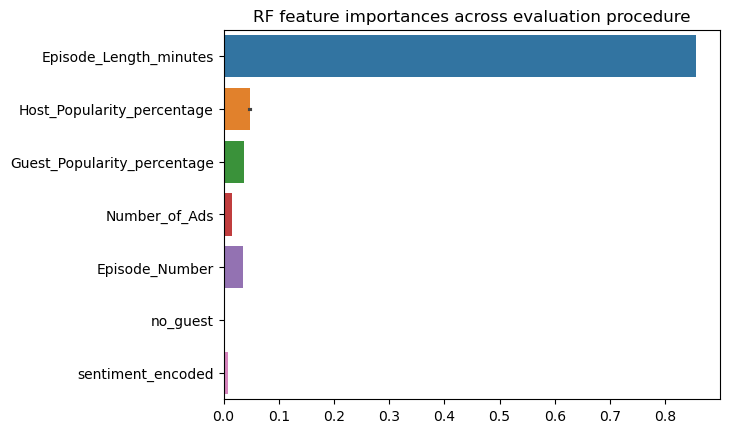

In [14]:
rf_importance(models_rf_abs, X_only_numeric.columns)

## Sobre target relativo

In [15]:
res_rf_rel, models_rf_rel = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=True,
    model_args=dict(n_jobs=-1)
)

100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


In [16]:
res_rf_rel

,mae,mse,rmse
0,9.068968,134.216089,11.585167
1,8.884777,130.067716,11.404723
2,8.949942,132.122643,11.494461
3,8.971855,131.479948,11.466471
4,9.052143,133.696432,11.562717
mean,8.985537,132.316566,11.502708
std,0.075835,1.681300,0.073114


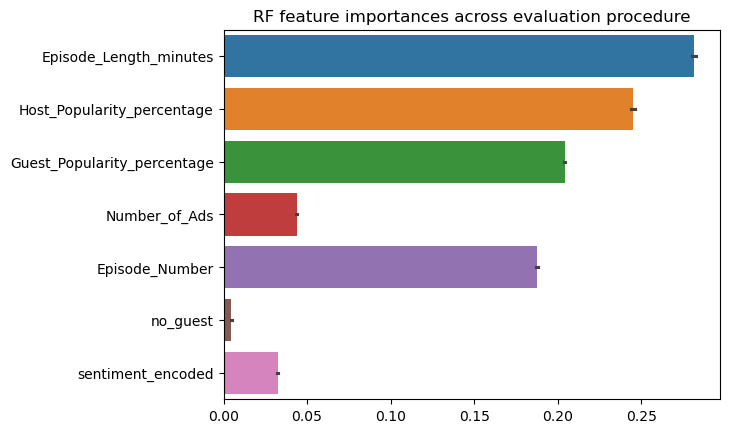

In [17]:
rf_importance(models_rf_rel, X_only_numeric.columns)

Se observa que la diferencia en performance entre usar target relativo y absoluto es mínima, aunque favorece levemente al target relativo.

Sin embargo, debe destacarse que el modelo con target relativo utiliza mucho mejor las diferentes features, mientras que el absoluto se concentra casi exclusivamente en la duración del podcast.

# Baseline + variables categóricas

## One Hot Encoding

In [18]:
res_onehot_rel, models_onehot_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (OneHotEncoder(sparse_output=False), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:42<00:00,  8.56s/it]


In [19]:
res_onehot_rel

,mae,mse,rmse
0,9.006525,131.202598,11.454370
1,8.833524,126.818381,11.261367
2,8.865154,128.928412,11.354665
3,8.900260,128.408491,11.331747
4,8.885073,127.935024,11.310837
mean,8.898107,128.658581,11.342597
std,0.065547,1.621515,0.071351


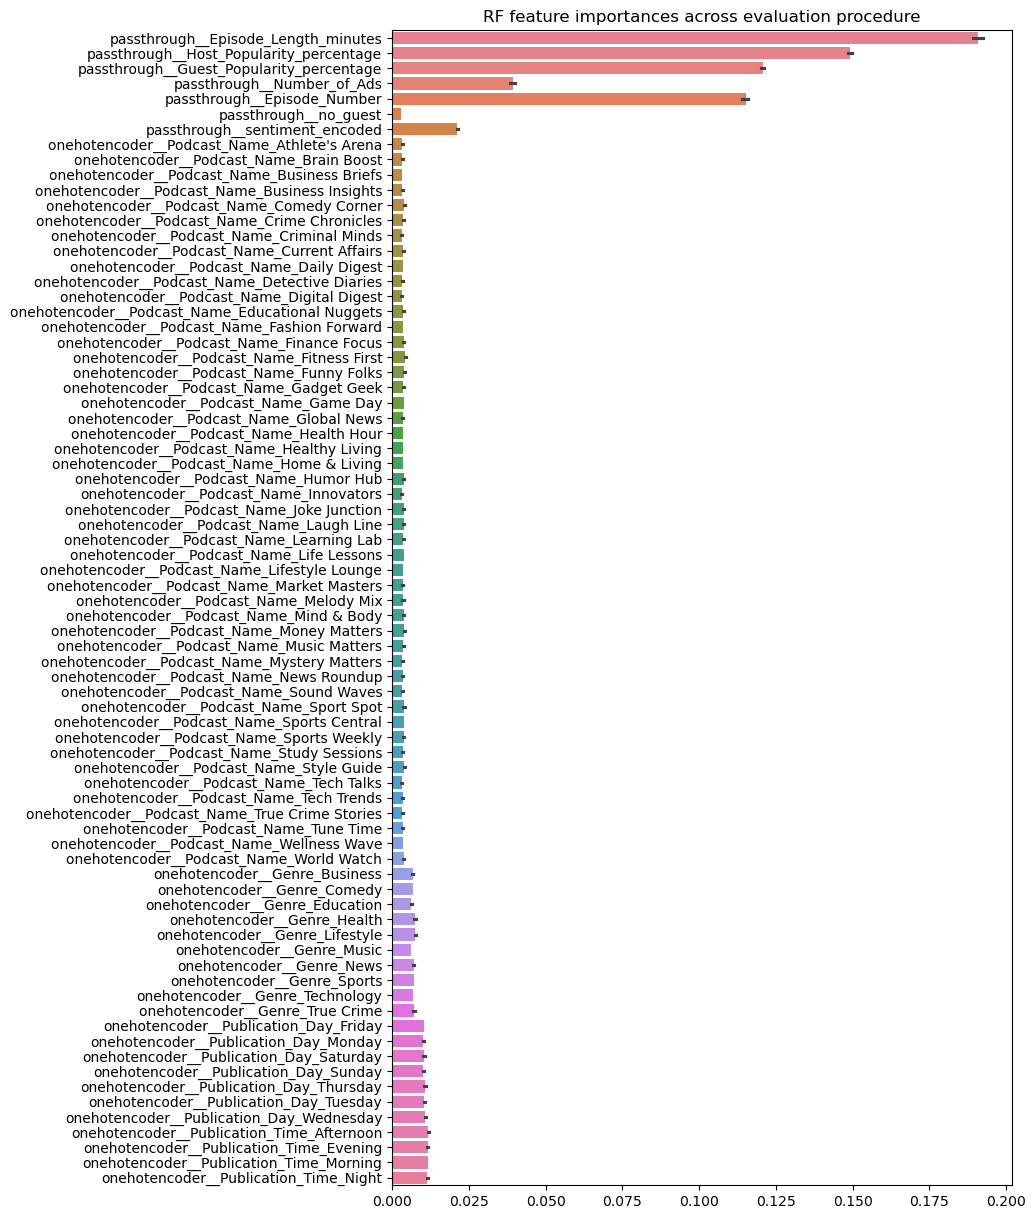

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots(figsize=(8,15))
rf_importance(models_onehot_rel, models_onehot_rel[0][-2].get_feature_names_out())
plt.tight_layout()

## Target Encoding

In [21]:
res_tgt_rel, models_tgt_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:27<00:00,  5.40s/it]


In [22]:
res_tgt_rel

,mae,mse,rmse
0,8.955339,129.736565,11.390196
1,8.834003,127.187087,11.277725
2,8.841319,127.624323,11.297094
3,8.851444,126.032703,11.226429
4,8.910155,128.309812,11.327392
mean,8.878452,127.778098,11.303767
std,0.052442,1.372740,0.060688


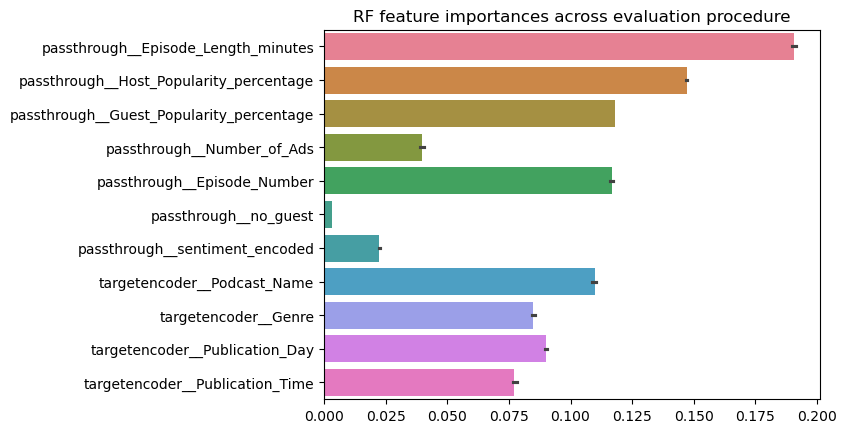

In [23]:
rf_importance(models_tgt_rel, models_tgt_rel[0][-2].get_feature_names_out())

Como se puede observar, la performance de las categorías encodeadas vía Target Encoding es superior a la de One Hot Encoding, incluso para aquellas de baja cardinalidad. Cabe destacar que el Target Encoder tiene hiperparámetros que no han sido tuneados, se están utilizando los default.

# Feature Engineering

In [24]:
from itertools import combinations
# cantidad media de ads por minuto 
X['ad_density'] = X['Number_of_Ads'] / X['Episode_Length_minutes']

# popularidad sumada de Host y Guest
X['joint_popularity'] = X['Host_Popularity_percentage'] + X['Guest_Popularity_percentage']

# como son pocas categóricas, se pueden hacer combinaciones y luego encodearlas por algún tipo de target encoding
for n in range(2,len(cat_cols)+1):
    for cols in combinations(cat_cols,n):
        cols_list = list(cols) # pandas gets angry if they're tuples instead of lists
        # X[f"comb_{n}_"+"+".join(cols)] = X[cols_list].apply(lambda s: '-'.join(s), axis=1)"""
        X[f"comb_{n}_"+"+".join(cols)] = X[cols_list].apply(lambda s: '-'.join(s), axis=1)


In [25]:
comb_cols = X.columns[X.columns.str.startswith('comb_')].tolist()

In [26]:
# Visualización inicial
X.head().T

,0,1,2,3,4
Podcast_Name,Healthy Living,Mystery Matters,Current Affairs,Mystery Matters,Money Matters
Episode_Length_minutes,99.25,19.43,117.03,16.97,28.06
Genre,Health,True Crime,News,True Crime,Business
Host_Popularity_percentage,21.37,47.19,96.33,25.73,22.02
Publication_Day,Thursday,Friday,Sunday,Monday,Wednesday
Publication_Time,Night,Evening,Night,Night,Morning
Guest_Popularity_percentage,70.22,75.15,57.95,24.19,-1.0
Number_of_Ads,3,1,3,0,1
Episode_Number,77,6,1,38,87
no_guest,False,False,False,False,True


Probamos su importancia utilizando un Random Forest con Target Encoding y valores default como antes.

In [27]:
res_fe_rel, models_fe_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [01:12<00:00, 14.49s/it]


In [28]:
res_fe_rel

,mae,mse,rmse
0,8.931999,128.451392,11.333640
1,8.768543,125.102201,11.184910
2,8.786153,125.357722,11.196326
3,8.828228,125.216051,11.189998
4,8.894441,127.652061,11.298321
mean,8.841873,126.355885,11.240639
std,0.069918,1.576269,0.070018


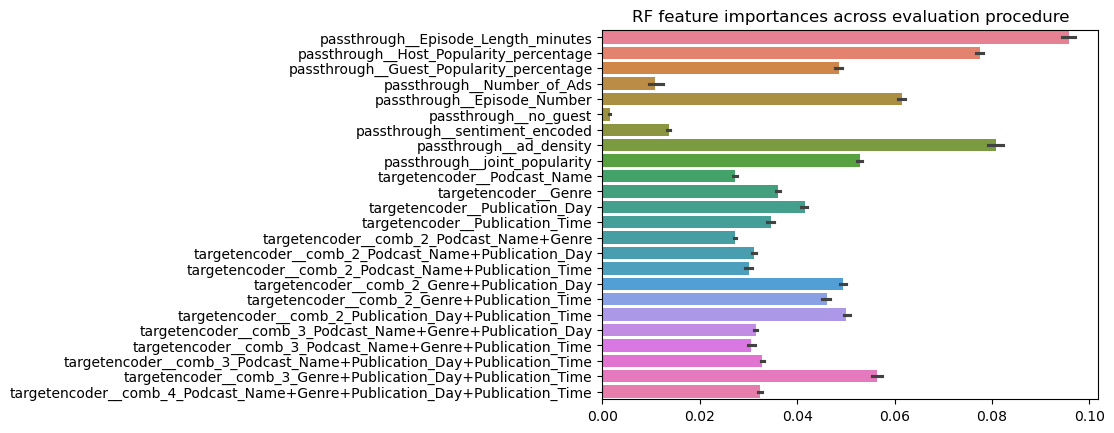

In [29]:
rf_importance(models_fe_rel, models_fe_rel[0][-2].get_feature_names_out())

Como se puede apreciar, con las nuevas variables el RMSE baja de 11.31 a 11.23 y el MAE de 8.88 a 8.83 (en media sobre 5 folds). Además la importancia de las variables es bastante alta y con poca variabilidad entre folds, lo que indica que tienen poder predictivo.

Por completitud se estima la performance utilizando target absoluto:

In [30]:
res_fe_abs, models_fe_abs = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=False
)

res_fe_abs

100%|██████████| 5/5 [01:02<00:00, 12.59s/it]


,mae,mse,rmse
0,8.931975,129.233774,11.368103
1,8.770951,124.920532,11.176785
2,8.850568,127.510993,11.292077
3,8.860843,126.914141,11.265618
4,8.894591,127.883315,11.308551
mean,8.861785,127.292551,11.282227
std,0.059959,1.575971,0.069926


Como era de esperarse, la performance es peor. Se confirma entonces que es mejor utilizar el target relativo.

# Testeo de diferentes modelos

In [31]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

def make_preprocessed_pipeline(model, numeric_cols, cat_cols):
    preprocessor = make_column_transformer(
        ('passthrough', numeric_cols),
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        remainder='drop',
        sparse_threshold=0,
    )
    
    return make_pipeline(preprocessor, StandardScaler(), model)

In [32]:
from sklearn.linear_model import Lasso, Ridge
res_lasso_rel, models_lasso_rel = cv_model(
    lambda: make_preprocessed_pipeline(Lasso(alpha=0.1), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


In [33]:
res_lasso_rel

,mae,mse,rmse
0,9.209609,140.167239,11.839225
1,9.085107,136.077064,11.665207
2,9.125548,137.878952,11.742187
3,9.181672,137.886407,11.742504
4,9.198843,138.803393,11.781485
mean,9.160156,138.162611,11.754122
std,0.052998,1.494607,0.063589


In [34]:
res_ridge_rel, models_ridge_rel = cv_model(
    lambda: make_preprocessed_pipeline(Ridge(alpha=1.0), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


In [35]:
res_ridge_rel

,mae,mse,rmse
0,8.877918,126.952204,11.267307
1,8.752063,123.962696,11.133854
2,8.804853,125.246857,11.191374
3,8.796154,124.144580,11.142019
4,8.856516,125.605072,11.207367
mean,8.817501,125.182282,11.188384
std,0.050175,1.212411,0.054133


In [36]:
from sklearn.svm import SVR
# Comentado porque demora mucho tiempo (algunos minutos)
"""res_svr_rel, models_svr_rel = cv_model(
    lambda: make_preprocessed_pipeline(SVR(C=1.0, epsilon=0.1), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

res_svr_rel"""

'res_svr_rel, models_svr_rel = cv_model(\n    lambda: make_preprocessed_pipeline(SVR(C=1.0, epsilon=0.1), numeric_cols, cat_cols),\n    X=X,\n    is_rel=True\n)\n\nres_svr_rel'

In [37]:
# ejemplo de LightGBM
from lightgbm import LGBMRegressor

X_cats = X.copy()

for col in cat_cols+comb_cols:
    X_cats[col] = X_cats[col].astype("category")

X_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   Podcast_Name                                                40374 non-null  category
 1   Episode_Length_minutes                                      40374 non-null  float64 
 2   Genre                                                       40374 non-null  category
 3   Host_Popularity_percentage                                  40374 non-null  float64 
 4   Publication_Day                                             40374 non-null  category
 5   Publication_Time                                            40374 non-null  category
 6   Guest_Popularity_percentage                                 40374 non-null  float64 
 7   Number_of_Ads                                               40374 non-null  

In [38]:
res_lgb_rel, models_lgb_rel = cv_model(
    lambda : LGBMRegressor(num_leaves=31, max_bin=2048, subsample=1., subsample_freq=8, colsample_bytree=0.9),
    X=X_cats,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14633
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 24
[LightGBM] [Info] Start training from score 0.713479


 20%|██        | 1/5 [00:00<00:02,  1.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14632
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 24
[LightGBM] [Info] Start training from score 0.713263


 40%|████      | 2/5 [00:01<00:01,  1.79it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14631
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 24
[LightGBM] [Info] Start training from score 0.712785


 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14633
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 24
[LightGBM] [Info] Start training from score 0.713100


 80%|████████  | 4/5 [00:02<00:00,  1.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14634
[LightGBM] [Info] Number of data points in the train set: 32300, number of used features: 24
[LightGBM] [Info] Start training from score 0.712298


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


In [39]:
res_lgb_rel

,mae,mse,rmse
0,9.137237,135.523631,11.641462
1,9.010697,132.784981,11.523237
2,9.001472,135.010756,11.619413
3,8.977305,132.087893,11.492950
4,9.067912,134.330331,11.590096
mean,9.038925,133.947519,11.573431
std,0.064230,1.463801,0.063279


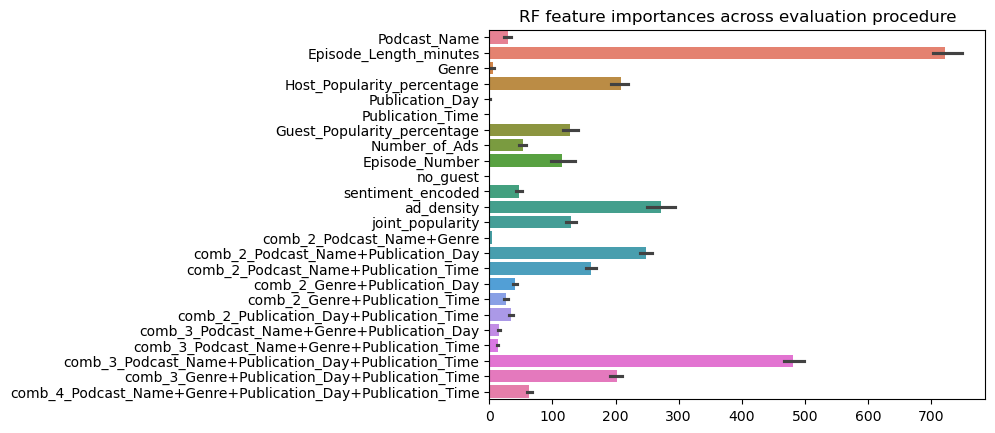

In [40]:
rf_importance(models_lgb_rel, X_cats.columns)

Parece que anda mal por insistencia en concentrarse en las mismas features, tal vez por eso anda mejor el RF? Ver los demás.


### Mini feature selection y HP Tunning con Optuna Y W&B

In [41]:
import optuna
import tqdm as notebook_tqdm

def objective_random_forest(trial):
    #n_estimators = trial.suggest_int('n_estimators', 50, 200)
    #max_depth = trial.suggest_int('max_depth', 2, 20)
    #min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    n_estimators = trial.suggest_int('n_estimators', 50, 100) 
    max_depth = trial.suggest_int('max_depth', 3, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )

    pipeline = make_preprocessed_pipeline(model, numeric_cols, cat_cols)

    score, _ = cv_model(
        lambda: pipeline,
        X=X,
        is_rel=True
    )

    return score['rmse'].mean()

# Descomentar para ejecutar la optimización sin W&B
#study = optuna.create_study(direction="minimize") 
#study.optimize(objective_random_forest, n_trials=10)

/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
import wandb
wandb.login()


wandb: Currently logged in as: gustavoramoscelli (gustavoramoscelli-universidad-nacional-del-sur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [43]:
from optuna.integration.wandb import WeightsAndBiasesCallback

wandb_kwargs = {
    "project": "optuna-rf", 
    "name": "random-forest-optimization",
    "mode": "offline"
}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest, n_trials=10, callbacks=[wandbc])


/tmp/ipykernel_650958/22922399.py:8: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=False)


[I 2025-04-24 12:14:54,817] A new study created in memory with name: no-name-133bb2bb-9090-4148-87e4-c1dc426eabfd
100%|██████████| 5/5 [00:10<00:00,  2.08s/it]
[I 2025-04-24 12:15:05,241] Trial 0 finished with value: 9.559187880588805 and parameters: {'n_estimators': 72, 'max_depth': 4, 'min_samples_split': 10}. Best is trial 0 with value: 9.559187880588805.
100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
[I 2025-04-24 12:15:14,008] Trial 1 finished with value: 9.626243183097992 and parameters: {'n_estimators': 71, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 0 with value: 9.559187880588805.
100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
[I 2025-04-24 12:15:22,549] Trial 2 finished with value: 9.62634100655242 and parameters: {'n_estimators': 67, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 0 with value: 9.559187880588805.
100%|██████████| 5/5 [00:12<00:00,  2.47s/it]
[I 2025-04-24 12:15:34,916] Trial 3 finished with value: 9.509660424012191 and parameters: {'n_estimat

In [44]:
print("Mejores parámetros:", study.best_params)
print("Mejor valor de la métrica (RMSE):", study.best_value)

Mejores parámetros: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 5}
Mejor valor de la métrica (RMSE): 9.509269598087274


In [45]:
from sklearn.ensemble import GradientBoostingRegressor

def objective_gradient_boosting(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 3, 6)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    pipeline = make_preprocessed_pipeline(model, numeric_cols, cat_cols)
    score, _ = cv_model(lambda: pipeline, X=X, is_rel=True)

    return score['rmse'].mean()


In [46]:
wandb_kwargs = {
    "project": "optuna-gbr", 
    "name": "gradient-boosting-optimization"
}

wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)

study = optuna.create_study(direction="minimize")
study.optimize(objective_gradient_boosting, n_trials=10, callbacks=[wandbc])

/tmp/ipykernel_650958/636689585.py:6: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)
[I 2025-04-24 12:16:35,349] A new study created in memory with name: no-name-77fcfdfc-43e4-44ab-890a-9bc4415894f2
100%|██████████| 5/5 [00:49<00:00,  9.99s/it]
[I 2025-04-24 12:17:25,319] Trial 0 finished with value: 9.511211338401038 and parameters: {'learning_rate': 0.18624677141681809, 'n_estimators': 75, 'max_depth': 4}. Best is trial 0 with value: 9.511211338401038.


max_depth,▃▁▁██▁▁▁█▃
min_samples_split,█▄▄▂▃▆▃▁▄█
n_estimators,▄▄▃▅█▁▄▇▁▄
value,▄██▁▁███▁▄
max_depth,4
min_samples_split,10
n_estimators,73
value,9.55931


100%|██████████| 5/5 [01:12<00:00, 14.58s/it]
[I 2025-04-24 12:18:38,255] Trial 1 finished with value: 9.549566349241257 and parameters: {'learning_rate': 0.1899687589999156, 'n_estimators': 77, 'max_depth': 6}. Best is trial 0 with value: 9.511211338401038.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.18997
max_depth,6
n_estimators,77
trial_number,1
value,9.54957


100%|██████████| 5/5 [00:55<00:00, 11.10s/it]
[I 2025-04-24 12:19:37,349] Trial 2 finished with value: 9.50235799664031 and parameters: {'learning_rate': 0.038785512566076596, 'n_estimators': 75, 'max_depth': 5}. Best is trial 2 with value: 9.50235799664031.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.03879
max_depth,5
n_estimators,75
trial_number,2
value,9.50236


100%|██████████| 5/5 [01:03<00:00, 12.67s/it]
[I 2025-04-24 12:20:44,563] Trial 3 finished with value: 9.634751574628506 and parameters: {'learning_rate': 0.010392303204550127, 'n_estimators': 76, 'max_depth': 6}. Best is trial 2 with value: 9.50235799664031.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.01039
max_depth,6
n_estimators,76
trial_number,3
value,9.63475


100%|██████████| 5/5 [00:40<00:00,  8.06s/it]
[I 2025-04-24 12:21:28,415] Trial 4 finished with value: 9.512037181079453 and parameters: {'learning_rate': 0.15928997633274808, 'n_estimators': 52, 'max_depth': 5}. Best is trial 2 with value: 9.50235799664031.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.15929
max_depth,5
n_estimators,52
trial_number,4
value,9.51204


100%|██████████| 5/5 [00:28<00:00,  5.77s/it]
[I 2025-04-24 12:22:01,022] Trial 5 finished with value: 9.493961834945264 and parameters: {'learning_rate': 0.13679846357566205, 'n_estimators': 58, 'max_depth': 3}. Best is trial 5 with value: 9.493961834945264.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.1368
max_depth,3
n_estimators,58
trial_number,5
value,9.49396


100%|██████████| 5/5 [01:03<00:00, 12.72s/it]
[I 2025-04-24 12:23:08,575] Trial 6 finished with value: 9.550997861179747 and parameters: {'learning_rate': 0.2725698845243194, 'n_estimators': 100, 'max_depth': 4}. Best is trial 5 with value: 9.493961834945264.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.27257
max_depth,4
n_estimators,100
trial_number,6
value,9.551


100%|██████████| 5/5 [00:45<00:00,  9.01s/it]
[I 2025-04-24 12:23:57,132] Trial 7 finished with value: 9.5012169819727 and parameters: {'learning_rate': 0.1269646190541025, 'n_estimators': 71, 'max_depth': 4}. Best is trial 5 with value: 9.493961834945264.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.12696
max_depth,4
n_estimators,71
trial_number,7
value,9.50122


100%|██████████| 5/5 [00:42<00:00,  8.51s/it]
[I 2025-04-24 12:24:43,233] Trial 8 finished with value: 9.513992569390268 and parameters: {'learning_rate': 0.20765315824407585, 'n_estimators': 66, 'max_depth': 4}. Best is trial 5 with value: 9.493961834945264.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.20765
max_depth,4
n_estimators,66
trial_number,8
value,9.51399


100%|██████████| 5/5 [01:12<00:00, 14.40s/it]
[I 2025-04-24 12:25:59,213] Trial 9 finished with value: 9.54840960406498 and parameters: {'learning_rate': 0.1809848862056838, 'n_estimators': 79, 'max_depth': 6}. Best is trial 5 with value: 9.493961834945264.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.18098
max_depth,6
n_estimators,79
trial_number,9
value,9.54841


In [47]:
print("Mejores parámetros:", study.best_params)
print("Mejor valor de la métrica (RMSE):", study.best_value)

Mejores parámetros: {'learning_rate': 0.13679846357566205, 'n_estimators': 58, 'max_depth': 3}
Mejor valor de la métrica (RMSE): 9.493961834945264


#### Ridge regression

In [48]:
from sklearn.linear_model import Ridge

# Entrenamiento de Ridge Regression con OneHot + StandardScaler
res_ridge_rel, models_ridge_rel = cv_model(
    lambda: make_preprocessed_pipeline(
        Ridge(alpha=1.0, random_state=42),
        numeric_cols,
        cat_cols
    ),
    X=X,
    is_rel=True
)

# Mostrar todas las métricas promedio y su desviación estándar
print("Ridge Regression - Métricas completas:")
display(res_ridge_rel.describe().loc[['mean', 'std']])

# Mostrar solo RMSE promedio y std
rmse_mean = res_ridge_rel['rmse'].mean()
rmse_std = res_ridge_rel['rmse'].std()
print(f"RMSE promedio: {rmse_mean:.4f} ± {rmse_std:.4f}")


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

Ridge Regression - Métricas completas:


,mae,mse,rmse
mean,7.565026,107.472300,9.597777
std,3.313991,46.866663,4.208584


RMSE promedio: 9.5978 ± 4.2086
